In [1]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import time

In [2]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=30,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv3 = Conv2d(in_channels=30, out_channels=40,
			kernel_size=(5, 5))
		self.relu3 = ReLU()
		self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv4 = Conv2d(in_channels=40, out_channels=50,
			kernel_size=(5, 5))
		self.relu4 = ReLU()
		self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv5 = Conv2d(in_channels=50, out_channels=60,
			kernel_size=(5, 5))
		self.relu5 = ReLU()
		self.maxpool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=900, out_features=500)
		self.relu3 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		#print(f"shape after first conv: {x.shape}")
		x = self.relu1(x)
		x = self.maxpool1(x)
		#print(f"shape after first maxpool: {x.shape}")
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		#print(f"shape after second conv: {x.shape}")
		x = self.relu2(x)
		x = self.maxpool2(x)
		#print(f"shape after second maxpool: {x.shape}")

		x = self.conv3(x)
		#print(f"shape after third conv: {x.shape}")
		x = self.relu3(x)
		x = self.maxpool3(x)
		#print(f"shape after third maxpool: {x.shape}")

		x = self.conv4(x)
		#print(f"shape after fourth conv: {x.shape}")
		x = self.relu4(x)
		x = self.maxpool4(x)
		#print(f"shape after fourth maxpool: {x.shape}")

		x = self.conv5(x)
		#print(f"shape after fifth conv: {x.shape}")
		x = self.relu5(x)
		x = self.maxpool5(x)
		#print(f"shape after fifth maxpool: {x.shape}")
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		#print(f"shape after flatten: {x.shape}")
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

In [3]:
class CustomDataset(Dataset):
	def __init__(self, annotations_file, img_dir):
		self.img_labels = pd.read_csv(annotations_file)
		self.img_dir = img_dir
		self.classes = self.img_labels['label'].unique()


	def __len__(self):
		return len(self.img_labels)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
		image = np.load(img_path)
		label = self.img_labels.iloc[idx, 1]
		return image, label


In [4]:
AUDIO_PATH = '../birdclef-2022-data/train_audio'
IMAGE_PATH = '../birdclef-2022-data/train_images/'

# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# collect data about data structure
from sklearn.preprocessing import LabelEncoder
all_data = []
for primary_label in os.listdir(IMAGE_PATH):
    all_data += [primary_label + '/' + x for x in os.listdir(IMAGE_PATH + primary_label)]

base_data = {'file_name': [], 'label': []}
for item in all_data:
    base_data['file_name'].append(item)
    base_data['label'].append(item.split('/')[0])

results = pd.DataFrame(base_data, columns = ['file_name', 'label'])

le = LabelEncoder()
labels = le.fit_transform(results['label'])
results['label'] = labels
print(results.head())
results.to_csv("annotated_data.csv", index=False)

                file_name  label
0  afrsil1/XC125458_0.npy      0
1  afrsil1/XC125458_1.npy      0
2  afrsil1/XC125458_2.npy      0
3  afrsil1/XC175522_0.npy      0
4  afrsil1/XC175522_1.npy      0


In [6]:
# load data
numTrainSamples = round(len(all_data) * TRAIN_SPLIT)
numValSamples = round(len(all_data) * VAL_SPLIT)

data_set = CustomDataset("annotated_data.csv", IMAGE_PATH)

(trainData, valData) = random_split(data_set, [numTrainSamples, numValSamples],generator=torch.Generator().manual_seed(42))

print(f"len training: {len(trainData)}, len test: {len(valData)}")

len training: 108632, len test: 36211


In [7]:
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [8]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=3,
	classes=len(data_set.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

[INFO] initializing the LeNet model...


In [9]:

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for data in trainDataLoader:
		# send the input to the device
		x, y = data
		x = x.transpose(1, 3)
		x = x.transpose(2, 3)
		x = x.float()
		x, y = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			x = x.transpose(1, 3)
			x = x.transpose(2, 3)
			x = x.float()
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 3.136309, Train accuracy: 0.2828
Val loss: 2.592143, Val accuracy: 0.3904

[INFO] EPOCH: 2/10
Train loss: 2.412478, Train accuracy: 0.4301
Val loss: 2.370619, Val accuracy: 0.4340

[INFO] EPOCH: 3/10
Train loss: 2.114588, Train accuracy: 0.4916
Val loss: 2.143210, Val accuracy: 0.4847

[INFO] EPOCH: 4/10
Train loss: 1.925962, Train accuracy: 0.5296
Val loss: 2.054919, Val accuracy: 0.5113

[INFO] EPOCH: 5/10
Train loss: 1.785182, Train accuracy: 0.5604
Val loss: 1.968104, Val accuracy: 0.5232

[INFO] EPOCH: 6/10
Train loss: 1.679196, Train accuracy: 0.5804
Val loss: 1.921139, Val accuracy: 0.5427

[INFO] EPOCH: 7/10
Train loss: 1.576921, Train accuracy: 0.6029
Val loss: 1.883086, Val accuracy: 0.5478

[INFO] EPOCH: 8/10
Train loss: 1.491606, Train accuracy: 0.6216
Val loss: 1.864403, Val accuracy: 0.5628

[INFO] EPOCH: 9/10
Train loss: 1.414301, Train accuracy: 0.6379
Val loss: 1.874081, Val accuracy: 0.5560

[INFO] EPOCH: 1

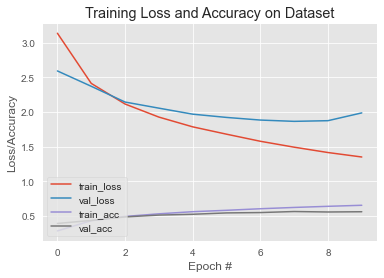

In [10]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [11]:
path_name = '../birdclef-2022-data/train_images/afrsil1/XC125458_0.npy'
spec = np.load(path_name)

print(spec.shape)
print(np.array_equal(spec[0], spec[1]))
print(spec)

(224, 313, 3)
False
[[[  0   0   0]
  [  0   0   0]
  [104 104 104]
  ...
  [216 216 216]
  [198 198 198]
  [217 217 217]]

 [[  0   0   0]
  [  0   0   0]
  [111 111 111]
  ...
  [220 220 220]
  [223 223 223]
  [230 230 230]]

 [[  0   0   0]
  [  0   0   0]
  [114 114 114]
  ...
  [232 232 232]
  [235 235 235]
  [234 234 234]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 36  36  36]
  [ 45  45  45]
  [ 53  53  53]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 10  10  10]
  [ 15  15  15]
  [ 45  45  45]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [ 45  45  45]]]


In [12]:
import torch, gc
def empy_gpu_cache():
	gc.collect()
	torch.cuda.empty_cache()

In [13]:
#empy_gpu_cache()